Load necessary packages and libraries 

In [1]:
import scipy.io 
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

2025-02-08 14:59:12.976590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 14:59:13.875789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-08 14:59:13.875936: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2025-02-08 14:59:13.875946: W tensorflow/compiler/tf2tensorrt/util

Import Data  

In [2]:
def ImportData():
  X99_normal = scipy.io.loadmat('BearingData_CaseWestern/99.mat')['X099_DE_time']              
  X111_InnerRace_007 = scipy.io.loadmat('BearingData_CaseWestern/111.mat')['X111_DE_time']
  X124_Ball_007 = scipy.io.loadmat('BearingData_CaseWestern/124.mat')['X124_DE_time']
  X137_Outer_007 = scipy.io.loadmat('BearingData_CaseWestern/137.mat')['X137_DE_time']
  X176_InnerRace_014 = scipy.io.loadmat('BearingData_CaseWestern/176.mat')['X176_DE_time']
  X191_Ball_014 = scipy.io.loadmat('BearingData_CaseWestern/191.mat')['X191_DE_time']
  X203_Outer_014 = scipy.io.loadmat('BearingData_CaseWestern/203.mat')['X203_DE_time']
  X215_InnerRace_021 = scipy.io.loadmat('BearingData_CaseWestern/215.mat')['X215_DE_time']
  X228_Ball_021 = scipy.io.loadmat('BearingData_CaseWestern/228.mat')['X228_DE_time']
  X240_Outer_021 = scipy.io.loadmat('BearingData_CaseWestern/240.mat')['X240_DE_time']
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]


def Sampling(Data, interval_length, samples_per_block):
  # Calculate the number of blocks that can be sampled based on the interval length 
  No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length)-1)
  SplitData = np.zeros([No_of_blocks, samples_per_block])
  for i in range(No_of_blocks):
    SplitData[i,:] = (Data[i*interval_length:(i*interval_length)+samples_per_block]).T
  return SplitData


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block)
    y = np.zeros([len(SplitData),10])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1])
    y1[:,0] = count
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  return X, LabelPositional, Label


Data = ImportData()
interval_length = 200  
samples_per_block = 1681


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

Shape of Input Data = (24276, 1681)
Shape of Label Y_CNN = (24276, 10)
Shape of Label Y = (24276, 1)


Export Input Data to MATLAB


*   For feature Extraction - time and frequency domain analysis  
*   For implementing Self Organizing Feature Maps using MATLAB 'nctool' feature



In [3]:
XX = {'X':X}
scipy.io.savemat('Data.mat', XX)

K-Fold Cross Validation 

In [4]:
# k-fold cross validation 
kSplits = 5
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)

**NEURAL NETWORK MODELS**

**1-Dimensional Convolutional Neural Network Classification**

In [5]:
# Reshape the data - 1 dimensional feed 
Input_1D = X.reshape([-1,1681,1])

# Test-Train Split 
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class CNN_1D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_1D = []

# Train the model 
for train, test in kfold.split(X_1D_train,y_1D_train):
  Classification_1D = CNN_1D()
  history = Classification_1D.model.fit(X_1D_train[train], y_1D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification_1D.model.evaluate(X_1D_train[test], y_1D_train[test]) 
  accuracy_1D.append(kf_accuracy)

CNN_1D_train_accuracy = np.average(accuracy_1D)*100
print('CNN 1D train accuracy =', CNN_1D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_1D_test_loss, CNN_1D_test_accuracy = Classification_1D.model.evaluate(X_1D_test, y_1D_test)
CNN_1D_test_accuracy*=100
print('CNN 1D test accuracy =', CNN_1D_test_accuracy)



2025-02-08 15:01:52.713925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:01:52.725150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:01:52.725459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-08 15:01:52.726126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Epoch 1/12


2025-02-08 15:01:55.953036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2025-02-08 15:01:56.598603: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f1dc1383770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-08 15:01:56.598652: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GRID P40-24Q, Compute Capability 6.1
2025-02-08 15:01:56.664004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-08 15:01:57.099938: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


456/456 [==============================] - 6s 4ms/step - loss: 0.8058 - accuracy: 0.6821
Epoch 2/12
456/456 [==============================] - 2s 4ms/step - loss: 0.3720 - accuracy: 0.8284
Epoch 3/12
456/456 [==============================] - 2s 4ms/step - loss: 0.2076 - accuracy: 0.9023
Epoch 4/12
456/456 [==============================] - 2s 4ms/step - loss: 0.1407 - accuracy: 0.9404
Epoch 5/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0867 - accuracy: 0.9661
Epoch 6/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0657 - accuracy: 0.9751
Epoch 7/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0561 - accuracy: 0.9786
Epoch 8/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0444 - accuracy: 0.9846
Epoch 9/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0409 - accuracy: 0.9871
Epoch 10/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0256 - accuracy: 0.9908
Epoch 11/1

Confusion Matrix Calculation

In [8]:
def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

Plot results - CNN 1D

569/569 [==============================] - 1s 2ms/step


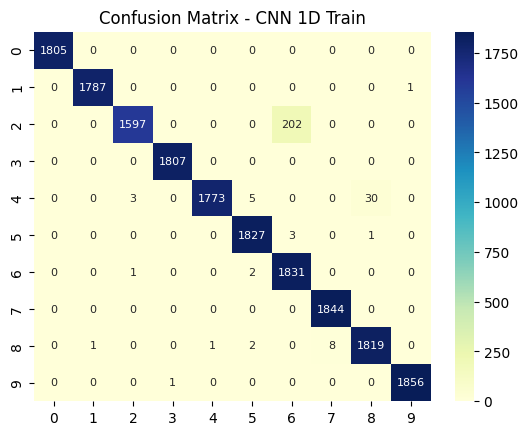

190/190 [==============================] - 0s 2ms/step


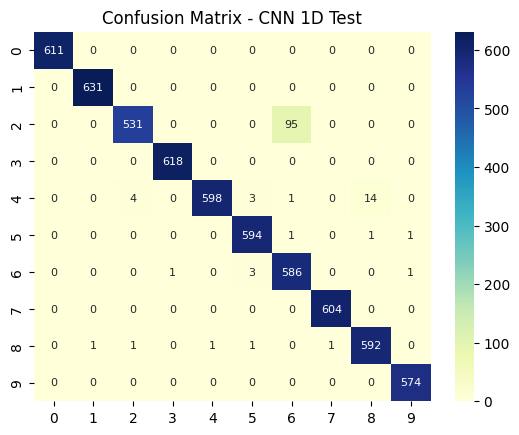

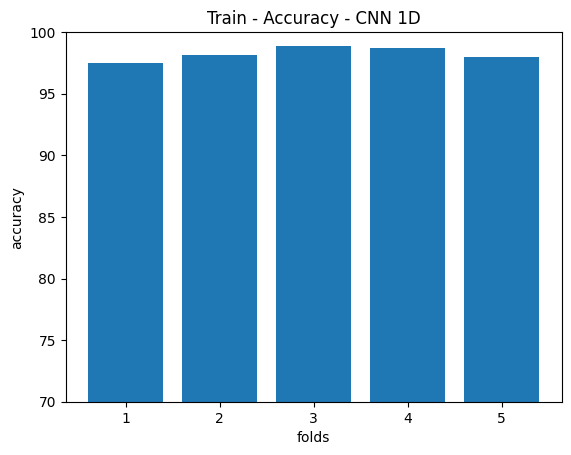

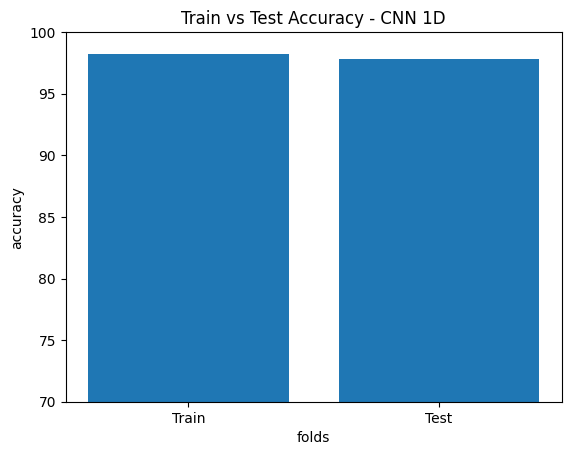

In [7]:
plt.figure(1)
plt.title('Confusion Matrix - CNN 1D Train') 
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_train, y_1D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(2)
plt.title('Confusion Matrix - CNN 1D Test') 
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_test, y_1D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(3)
plt.title('Train - Accuracy - CNN 1D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_1D])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(4)
plt.title('Train vs Test Accuracy - CNN 1D')
plt.bar([1,2],[CNN_1D_train_accuracy,CNN_1D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

**2-Dimensional Convolutional Neural Network Classification**

In [9]:
# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,41,41,1])

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3),strides=(2,2), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.InputLayer(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy_2D = []

# Train the model 
for train, test in kfold.split(X_2D_train,y_2D_train):
  Classification_2D = CNN_2D()
  history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=12)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_2D.append(kf_accuracy)

CNN_2D_train_accuracy = np.average(accuracy_2D)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
CNN_2D_test_accuracy*=100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)



Epoch 1/12
456/456 [==============================] - 4s 4ms/step - loss: 1.0112 - accuracy: 0.5943
Epoch 2/12
456/456 [==============================] - 2s 3ms/step - loss: 0.4238 - accuracy: 0.8266
Epoch 3/12
456/456 [==============================] - 2s 4ms/step - loss: 0.3299 - accuracy: 0.8621
Epoch 4/12
456/456 [==============================] - 2s 4ms/step - loss: 0.2875 - accuracy: 0.8805
Epoch 5/12
456/456 [==============================] - 2s 3ms/step - loss: 0.2453 - accuracy: 0.9028
Epoch 6/12
456/456 [==============================] - 2s 3ms/step - loss: 0.1951 - accuracy: 0.9264
Epoch 7/12
456/456 [==============================] - 2s 4ms/step - loss: 0.1352 - accuracy: 0.9499
Epoch 8/12
456/456 [==============================] - 2s 4ms/step - loss: 0.1083 - accuracy: 0.9604
Epoch 9/12
456/456 [==============================] - 2s 3ms/step - loss: 0.0904 - accuracy: 0.9672
Epoch 10/12
456/456 [==============================] - 2s 4ms/step - loss: 0.0781 - accuracy: 0.9716

Plot results - CNN 2D

569/569 [==============================] - 1s 2ms/step


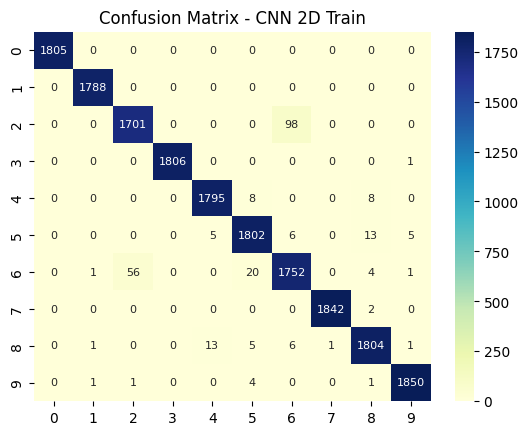

190/190 [==============================] - 0s 1ms/step


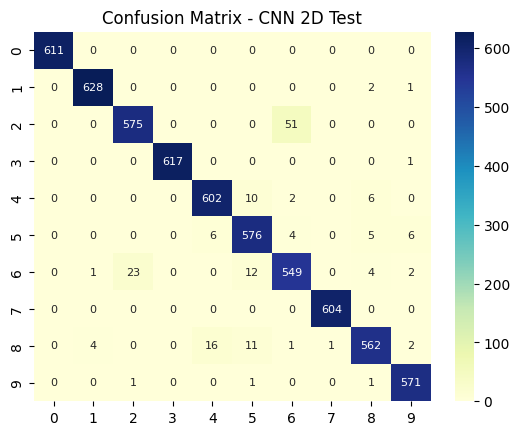

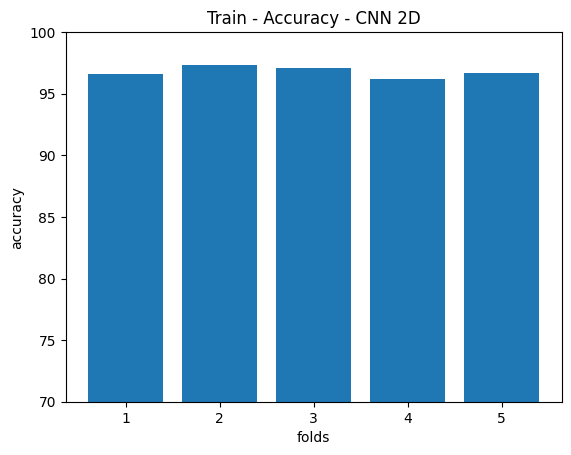

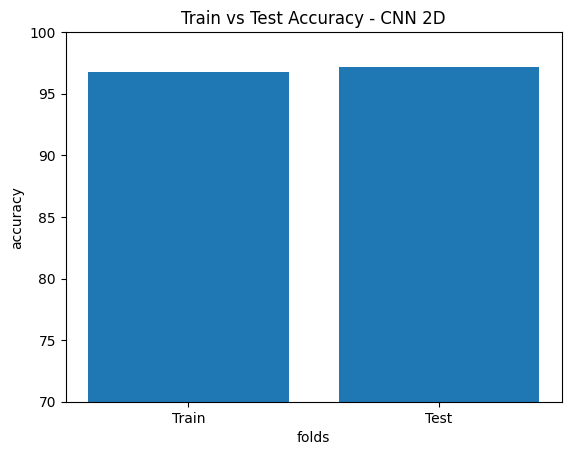

In [10]:
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(Classification_2D, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(Classification_2D, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_2D])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

**Long Short-Term Memory Recurrent Neural Network Classification Model** 

In [11]:
# Reshape the data - 1 dimensional feed 
Input = X.reshape([-1,1681,1])

# Test-Train Split 
X_train, X_test, y_train, y_test = train_test_split(Input, Y_CNN, train_size=0.75,test_size=0.25, random_state=101)

# Define the LSTM Classification model
class LSTM_Model():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.LSTM(32, return_sequences=True),
        layers.Flatten(),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model


accuracy = []

# Train the model 
for train, test in kfold.split(X_train,y_train):
  Classification = LSTM_Model()
  history = Classification.model.fit(X_train[train], y_train[train], verbose=1, epochs=10, use_multiprocessing=True)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification.model.evaluate(X_train[test], y_train[test]) 
  accuracy.append(kf_accuracy)

LSTM_train_accuracy = np.average(accuracy)*100
print('LSTM train accuracy =', LSTM_train_accuracy)


# Evaluate the accuracy of the model on the test set
LSTM_test_loss, LSTM_test_accuracy = Classification.model.evaluate(X_test, y_test)
LSTM_test_accuracy*=100
print('LSTM test accuracy =', LSTM_test_accuracy)



Epoch 1/10


456/456 [==============================] - 31s 63ms/step - loss: 1.2438 - accuracy: 0.5471
Epoch 2/10
456/456 [==============================] - 30s 66ms/step - loss: 0.4371 - accuracy: 0.8482
Epoch 3/10
456/456 [==============================] - 30s 65ms/step - loss: 0.2538 - accuracy: 0.9110
Epoch 4/10
456/456 [==============================] - 30s 65ms/step - loss: 0.2287 - accuracy: 0.9222
Epoch 5/10
456/456 [==============================] - 29s 64ms/step - loss: 0.2214 - accuracy: 0.9280
Epoch 6/10
456/456 [==============================] - 30s 66ms/step - loss: 0.1759 - accuracy: 0.9448
Epoch 7/10
456/456 [==============================] - 30s 65ms/step - loss: 0.1231 - accuracy: 0.9578
Epoch 8/10
456/456 [==============================] - 30s 66ms/step - loss: 0.1286 - accuracy: 0.9591
Epoch 9/10
456/456 [==============================] - 30s 66ms/step - loss: 0.0868 - accuracy: 0.9729
Epoch 10/10
114/114 [==============================] - 5s 42ms/step - loss: 0.2422 - accuracy

Plot results - LSTM Model

569/569 [==============================] - 23s 40ms/step


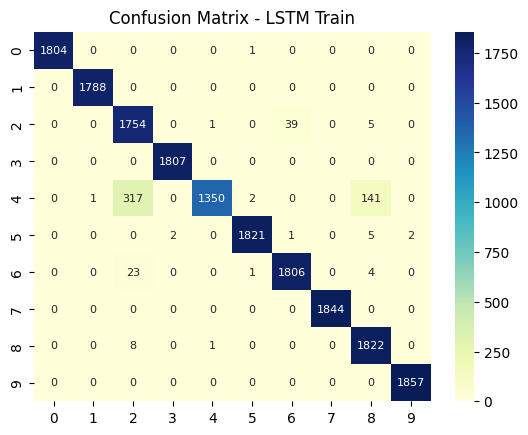

190/190 [==============================] - 8s 40ms/step


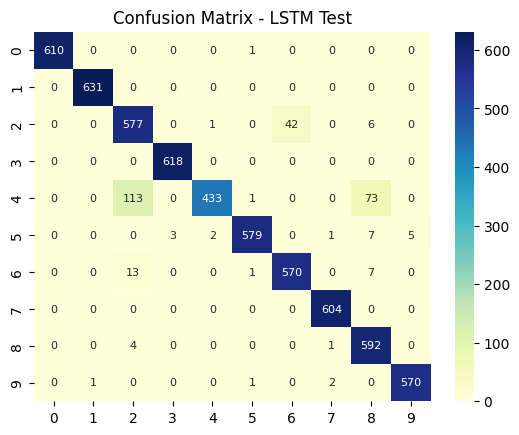

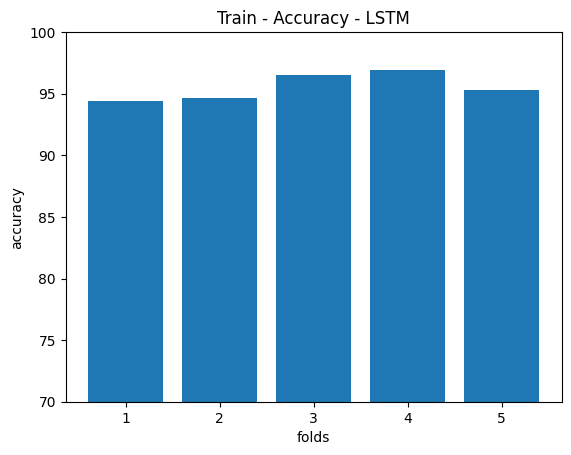

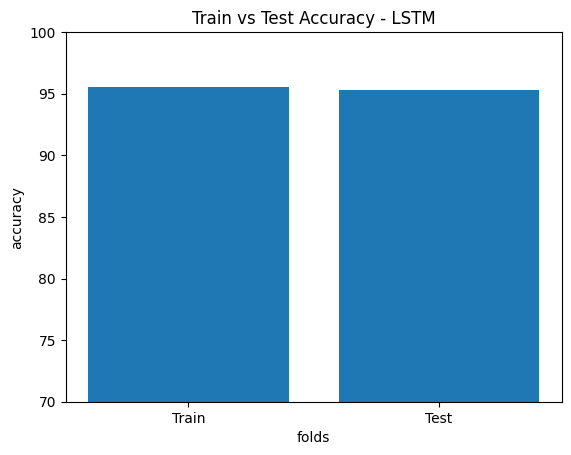

In [12]:

plt.figure(9)
plt.title('Confusion Matrix - LSTM Train') 
sns.heatmap(ConfusionMatrix(Classification, X_train, y_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(10)
plt.title('Confusion Matrix - LSTM Test') 
sns.heatmap(ConfusionMatrix(Classification, X_test, y_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(11)
plt.title('Train - Accuracy - LSTM')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(12)
plt.title('Train vs Test Accuracy - LSTM')
plt.bar([1,2],[LSTM_train_accuracy,LSTM_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()



**SUPPORT VECTOR MACHINE MODEL** 

Import Feature Data


*   The input data has been pre processed in MATLAB to extract the features like max, min, peak-to-peak, mean, variance, standard deviation, root-mean-square, skewness, crest factor, kurtosis in time domain, and amplitude and value of the maximum frequency in the frequency domains.






In [14]:
X_Features = scipy.io.loadmat('BearingData_CaseWestern/X_Features.mat')['Feature_Data']

# Feature data shape (no. of samples, no. of features)
X_Features.shape


(24276, 12)

Import packages and dependencies 

In [15]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm 
import warnings 
warnings.filterwarnings('ignore')

Normalize the Input Data

In [16]:
X_Norm = StandardScaler().fit_transform(X_Features)

Dimensionality Reduction - Principal Component Analysis 

In [17]:
pca = PCA(n_components=5)
Input_SVM_np = pca.fit_transform(X_Norm)
Input_SVM = pd.DataFrame(data = Input_SVM_np)
Label_SVM = pd.DataFrame(Y, columns = ['target'])

Define Parameters 

In [18]:
parameters = {'kernel':('rbf','poly','sigmoid'),
              'C': [0.01, 1],
              'gamma' : [0.01, 1],
              'decision_function_shape' : ['ovo']}

# Support vector Machine  
svm = SVC()

Train the Model

In [19]:
# Test-Train Split 
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(Input_SVM_np, Y, train_size=0.75,test_size=0.25, random_state=101)

# Train the model to obtain the best parameters
svm_cv = GridSearchCV(svm, parameters, cv=5)
svm_cv.fit(X_train_SVM, y_train_SVM)

print("Best parameters = ",svm_cv.best_params_)

SVM_train_accuracy = svm_cv.best_score_*100
print('SVM train accuracy =', SVM_train_accuracy)

# Evaluate the accuracy of the model on the test set
SVM_test_accuracy = svm_cv.score(X_test_SVM, y_test_SVM) 
SVM_test_accuracy*=100
print('SVM test accuracy =', SVM_test_accuracy)


Best parameters =  {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'rbf'}
SVM train accuracy = 92.81046553069329
SVM test accuracy = 92.55231504366452


Plot results - SVM

0.9367276322293623


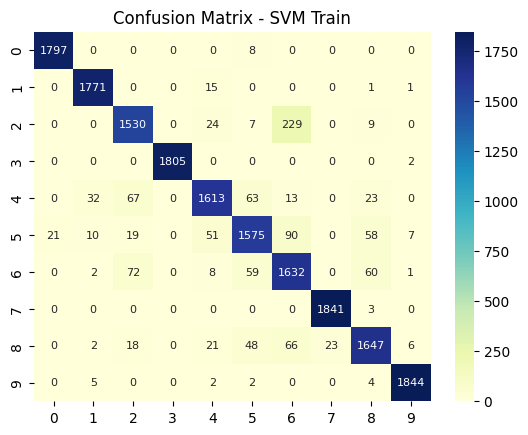

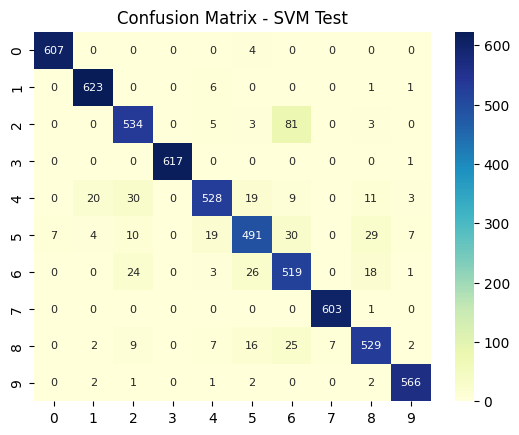

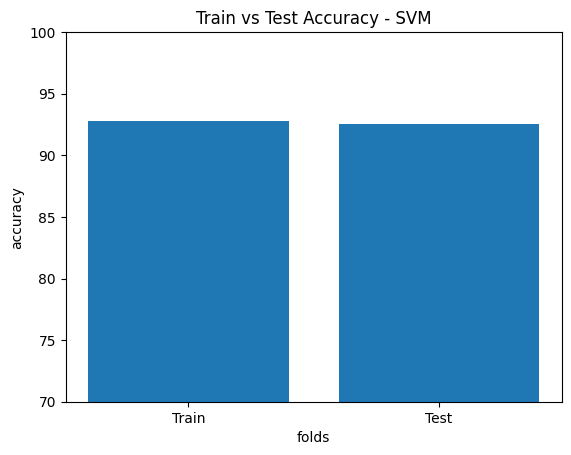

In [20]:
def ConfusionMatrix_SVM(Model, X, y):
  y_pred = Model.predict(X)
  ConfusionMat = confusion_matrix(y, y_pred)
  return ConfusionMat

print(svm_cv.score(X_train_SVM, y_train_SVM))

plt.figure(13)
plt.title('Confusion Matrix - SVM Train') 
sns.heatmap(ConfusionMatrix_SVM(svm_cv, X_train_SVM, y_train_SVM) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(14)
plt.title('Confusion Matrix - SVM Test') 
sns.heatmap(ConfusionMatrix_SVM(svm_cv, X_test_SVM, y_test_SVM) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(16)
plt.title('Train vs Test Accuracy - SVM')
plt.bar([1,2],[SVM_train_accuracy,SVM_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

Plot Decision boundaries in 2D

<Figure size 640x480 with 0 Axes>

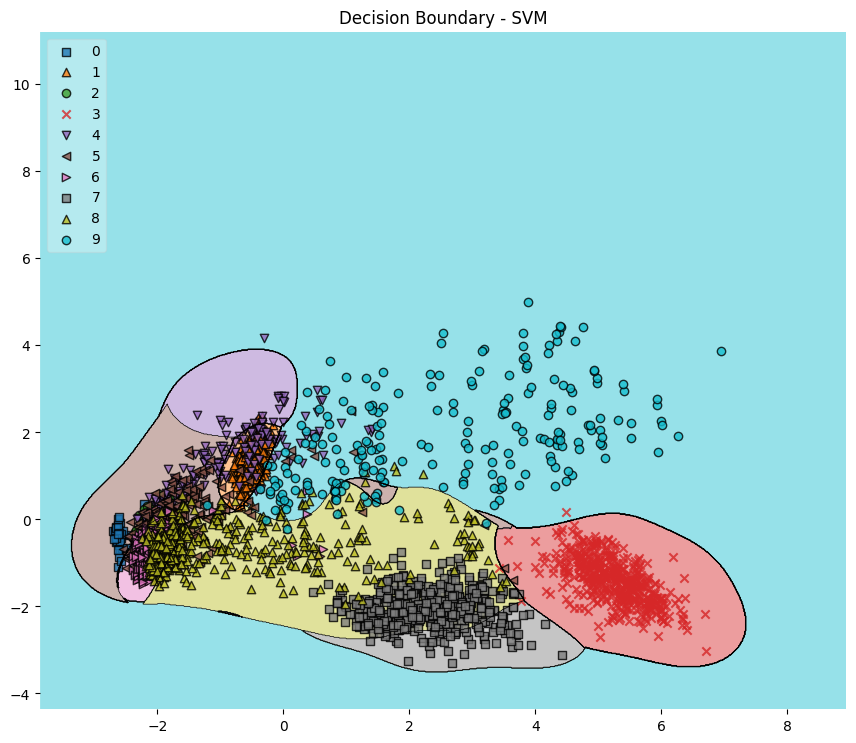

In [22]:
from mlxtend.plotting import plot_decision_regions
value = 0
width = 1
plt.figure(17)
plt.figure(figsize=(10.4,8.8))
plt.title('Decision Boundary - SVM')
plot_decision_regions(X_test_SVM, (y_test_SVM.astype(np.integer)).flatten(), clf=svm_cv, legend=2,
                  feature_index=[0,1],
                  filler_feature_values={2:value, 3:value, 4:value},
                  filler_feature_ranges={2:width, 3:width, 4:width},)
plt.show()

**COMPARISON OF MODELS**

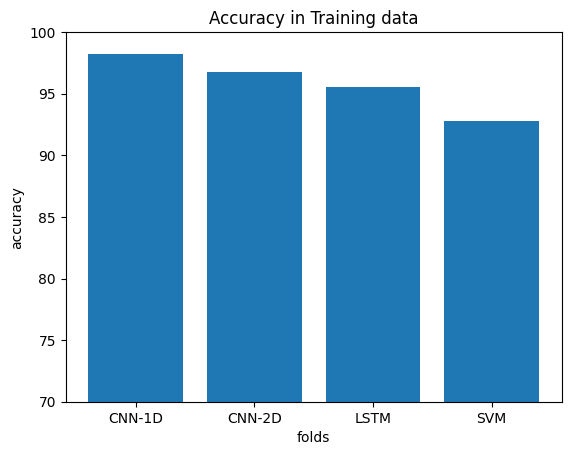

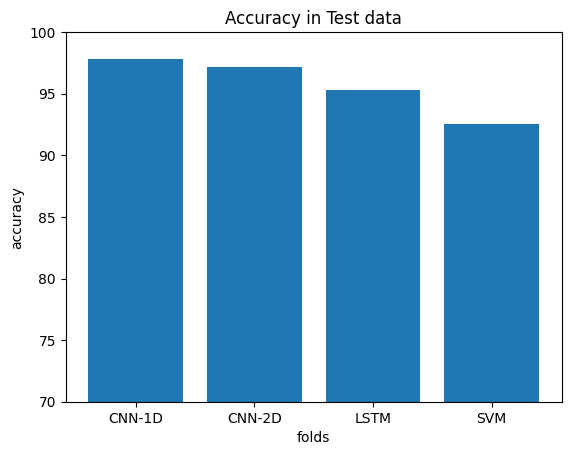

In [23]:
plt.figure(18)
plt.title('Accuracy in Training data')
plt.bar([1,2,3,4],[CNN_1D_train_accuracy, CNN_2D_train_accuracy, LSTM_train_accuracy, SVM_train_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2,3,4],['CNN-1D', 'CNN-2D' , 'LSTM', 'SVM'])
plt.ylim([70,100])
plt.show()


plt.figure(19)
plt.title('Accuracy in Test data')
plt.bar([1,2,3,4],[CNN_1D_test_accuracy, CNN_2D_test_accuracy, LSTM_test_accuracy, SVM_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2,3,4],['CNN-1D', 'CNN-2D' , 'LSTM', 'SVM'])
plt.ylim([70,100])
plt.show()